In [1]:
#%%writefile Get_FastPulse.py
#import ROOT
import copy
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import scipy.stats as stats 
import numpy as np
from scipy.fftpack import fft,ifft
from scipy.optimize import curve_fit
#pic_path=r'E:\CDEX\C1B\picture\波形处理\\'
#load text
#############

Eamp=np.load(r"E:\CDEX\C1B\data\AOE\E_625.npy")
# par=np.load(r"E:\CDEX\0vbb\Code\AE_par\Ecali_par.npy")
A=np.load(r"E:\CDEX\C1B\data\AOE\A_625.npy")

# A=np.load(r'G:/CDEX/wave_par/A_425_t7.npy')
# Eamp=np.load(r'G:/CDEX/wave_par/E_425_t7.npy')
Energy=np.zeros((Eamp.shape[0],))
AOE_array=np.zeros((A.shape[0],A.shape[1]))
print(Eamp.shape)
i=3
#par=np.load(r"E:\CDEX\0vbb\Code\AE_par\Ecali_par%d.npy"%i)

par=np.array([-2.22,0.19265])
Energy[:]=par[0]+Eamp[:,i]*par[1]
for i in range(A.shape[1]):
    AOE_array[:,i]=A[:,i]/Energy
print(A.shape)

x=Energy
i=1
normalized=AOE_array[np.argwhere(abs(Energy-1592)<3),i].mean()
AOE=AOE_array[:,i]
#/normalized

E_fit_point=np.array([1000,1200,1290,1400,1560,1760,1900,2050,2200])
Fit_point_range=np.array([25,  25,  15,  15,  15,  15,  20,  30,  30])


(3700000, 4)
(3700000, 2)


In [2]:
def sse_pdf(x,n,miu,sigma):
    t=-(x-miu)**2/(2*sigma**2)
    return n*np.exp(t)
def mse_pdf(x,p0,p1,p2,p3,p4,p5):
    return p0*(np.exp(p1*(x-p2))+p3)/(np.exp((x-p2)/p4)+p5)
def uper_tail(x,p1,p2):
    return np.maximum(x-p2,0)**0.5*p1
def AE_pdf(x,n,miu,sigma,p0,p1,p2,p3,p4,p5,p6):
    return sse_pdf(x,n,miu,sigma)+mse_pdf(x,p0,p1,p2,p3,p4,p5)+uper_tail(x,p6,p2)
def linear(x,a,b):
    return a+b*x
def c1b_mse_pdf(x,p0,p1,p2,p3,p4,p5):
    return p0*np.exp(p1*(p2-x))*(p2-x)**p3+p4*x**p5
def c1b_AE_pdf(x,n,miu,sigma,p0,p1,p2,p3,p4,p5):
    return sse_pdf(x,n,miu,sigma)+c1b_mse_pdf(x,p0,p1,p2,p3,p4,p5)
def poly(x,a,b,c):
    return a+b*x+c*x**2
def peak_pdf(x,n,miu,sigma,a,b,c):
    t=-(x-miu)**2/(2*sigma**2)
    return n*np.exp(t)+poly(x,a,b,c)
def dpeak_pdf(x,n1,miu1,sigma1,n2,miu2,sigma2,a,b,c):
    t1=-(x-miu1)**2/(2*sigma1**2)
    t2=-(x-miu2)**2/(2*sigma2**2)
    return n1*np.exp(t1)+n2*np.exp(t2)+poly(x,a,b,c)

def plt_adjust():
    plt.subplots_adjust(left=0.10, bottom=0.10, right=0.97, top=0.97,
                wspace=0.15, hspace=0.25)


In [3]:
def fit_sse_E(opt,cov,Epoint,save_path=None,fontsize_=14): #linear fit sse mean vs E and sigma vs E
    opt=np.array(opt)
    err=np.array(cov)
    E=np.array(Epoint)
    ###calibrate sse miu :
    sseu=opt[:,1]
    sseu_err=err[:,1]
    upar,ucov=curve_fit(poly,E,sseu)
    ex=np.linspace(1000,2400,100)
    uy=poly(ex,upar[0],upar[1],upar[2])

    ###calibrate sse sigma :
    ssesigma=opt[:,2]
    ssesigma_err=err[:,2]
    ssesigma_bound=[[-1,-1,0],[1,1,1e-12]]
    sigmapar,sigmacov=curve_fit(poly,E,ssesigma,bounds=ssesigma_bound)
    ex=np.linspace(1000,2400,100)
    sigmay=poly(ex,sigmapar[0],sigmapar[1],sigmapar[2])

    fig, ax = plt.subplots(2,1,figsize=(10, 5),dpi=900)
    ax[0].plot(ex,uy)
    ax[0].errorbar(E,sseu,yerr=sseu_err,fmt="o",markersize=5,markerfacecolor='none')
    ax[1].plot(ex,sigmay)
    ax[1].errorbar(E,ssesigma,yerr=ssesigma_err,fmt="o",markersize=3)

    ax[0].set_xlabel('Energy(keV)',fontsize=fontsize_,fontfamily='Times New Roman')
    ax[0].set_ylabel('SSE miu',fontsize=fontsize_,fontfamily='Times New Roman')
    ax[1].set_xlabel('Energy(keV)',fontsize=fontsize_,fontfamily='Times New Roman')
    ax[1].set_ylabel('SSE sigma',fontsize=fontsize_,fontfamily='Times New Roman')
    plt_adjust()
    plt.show()
    if(save_path):
        fig.savefig(save_path,format='svg')
    return upar, sigmapar

def GetParBound_sse(spec,bins):
    par=np.zeros((3,))
    bound=np.zeros((2,3))
    par[0]=spec.max() #gaus n
    bound[0][0]=par[0]*0.95
    bound[1][0]=par[0]*1.05
    par[1]=bins[spec.argmax()]#gaus mean
    bound[0][1]=par[1]*0.7
    bound[1][1]=par[1]*1.5
    par[2]=0.004 #gaus sigma
    bound[0][2]=par[2]*0.3
    bound[1][2]=par[2]*3    
    return par,bound

def rough_fit(E_fit_point,Fit_point_range,Energy,AOE,save_path=None):
    opt=[]
    cov=[]
    plot_bins=80
    plot_range=[0.65,0.95]
    fig, ax = plt.subplots(3,3,figsize=(12, 9),dpi=300)

    for i in range(9):
        energy_point=E_fit_point[i]
        energy_range=Fit_point_range[i]

        spec,bins,patchs=ax[int(i/3),i%3].hist(AOE[np.argwhere((abs(Energy-energy_point)<energy_range))],bins=plot_bins,range=plot_range,density=False,histtype='step',log=False,\
                              linewidth=0.8,color='red')
        par_set,bound_gaus=GetParBound_sse(spec,bins)

        print(par_set)

        t=(bins[0:len(spec)]+bins[1:])/2

        optf,covf=curve_fit(sse_pdf,t,spec,bounds=bound_gaus,p0=par_set)
        sse=sse_pdf(t,optf[0],optf[1],optf[2])

        ax[int(i/3),i%3].plot(t,sse)

        opt.append(optf)
        cov.append(np.sqrt(np.diag(covf)))
        ###fit
    ax[0,0].set(xlabel='A/E',ylabel='count')
    plt_adjust()
    plt.show()
    if(save_path):
        fig.savefig(save_path)
    
    return opt,cov

def accurate_fit(sse_mean_par,sse_sigma_par,Energy,AOE,plot_log=False,save_path=None,\
                 Epoint=E_fit_point,Erange=Fit_point_range,fontsize_=12):
    ##################### C1B
    #经验数据
    bound=[[100,  0.7, 0.003,0,   1,   0.6,  0.,  0,  0.85,0],\
           [10000,0.9,0.01, 3000,400, 0.85, 0.2, 0.1,7, 100]]
    opt=[]
    cov=[]
    plot_bins=160
    #plot_range=[0.75,1.1]
    plot_range=[0.65,0.95]
    
    fig, ax = plt.subplots(3,3,figsize=(12, 9),dpi=1200)
    
    for i in range(9):

        energy_point=Epoint[i]
        energy_range=Erange[i]

        spec,bins,patchs=ax[int(i/3),i%3].hist(AOE[np.argwhere((abs(Energy-energy_point)<energy_range))],bins=plot_bins,range=plot_range,density=False,histtype='step',log=False,\
                              linewidth=0.8,color='red')

        t=(bins[0:len(spec)]+bins[1:])/2

        par0=(np.array(bound[0])+np.array(bound[1]))/2

        par0[0]=spec.max()
        par0[1]=poly(energy_point,sse_mean_par[0],sse_mean_par[1],sse_mean_par[2])
        par0[2]=poly(energy_point,sse_sigma_par[0],sse_sigma_par[1],sse_sigma_par[2])


        bound[0][1],bound[1][1]=par0[1]-0.01,par0[1]+0.01

        optf,covf=curve_fit(AE_pdf,t,spec,bounds=bound,p0=par0)
        sse=sse_pdf(t,optf[0],optf[1],optf[2])

        mse=mse_pdf(t,optf[3],optf[4],optf[5],optf[6],optf[7],optf[8])
        tail=uper_tail(t,optf[9],optf[5])

        ax[int(i/3),i%3].plot(t,sse,color='y',label='SSE')
        ax[int(i/3),i%3].set_xlabel('A/E [%d,%d] keV'%(energy_point-energy_range,energy_point+energy_range),\
                      fontsize=fontsize_,fontfamily='Times New Roman')
        ax[int(i/3),i%3].plot(t,mse,color='g',label='MSE')
        ax[int(i/3),i%3].plot(t,tail,color='r',label='tail')
        ax[int(i/3),i%3].plot(t,sse+mse+tail,color='b',linestyle='--',label="SSE+MSE+tail")
        ax[int(i/3),i%3].legend()
        if(plot_log):
            ax[int(i/3),i%3].set_yscale('log')
            ax[int(i/3),i%3].set_ylim(1,700)
            
        
        opt.append(optf)
        cov.append(np.sqrt(np.diag(covf)))

    ax[0,0].set_ylabel("Count",fontsize=fontsize_,fontfamily='Times New Roman')

    plt_adjust()
    plt.show()
    if(save_path):
        fig.savefig(save_path,format='svg')

    return opt,cov

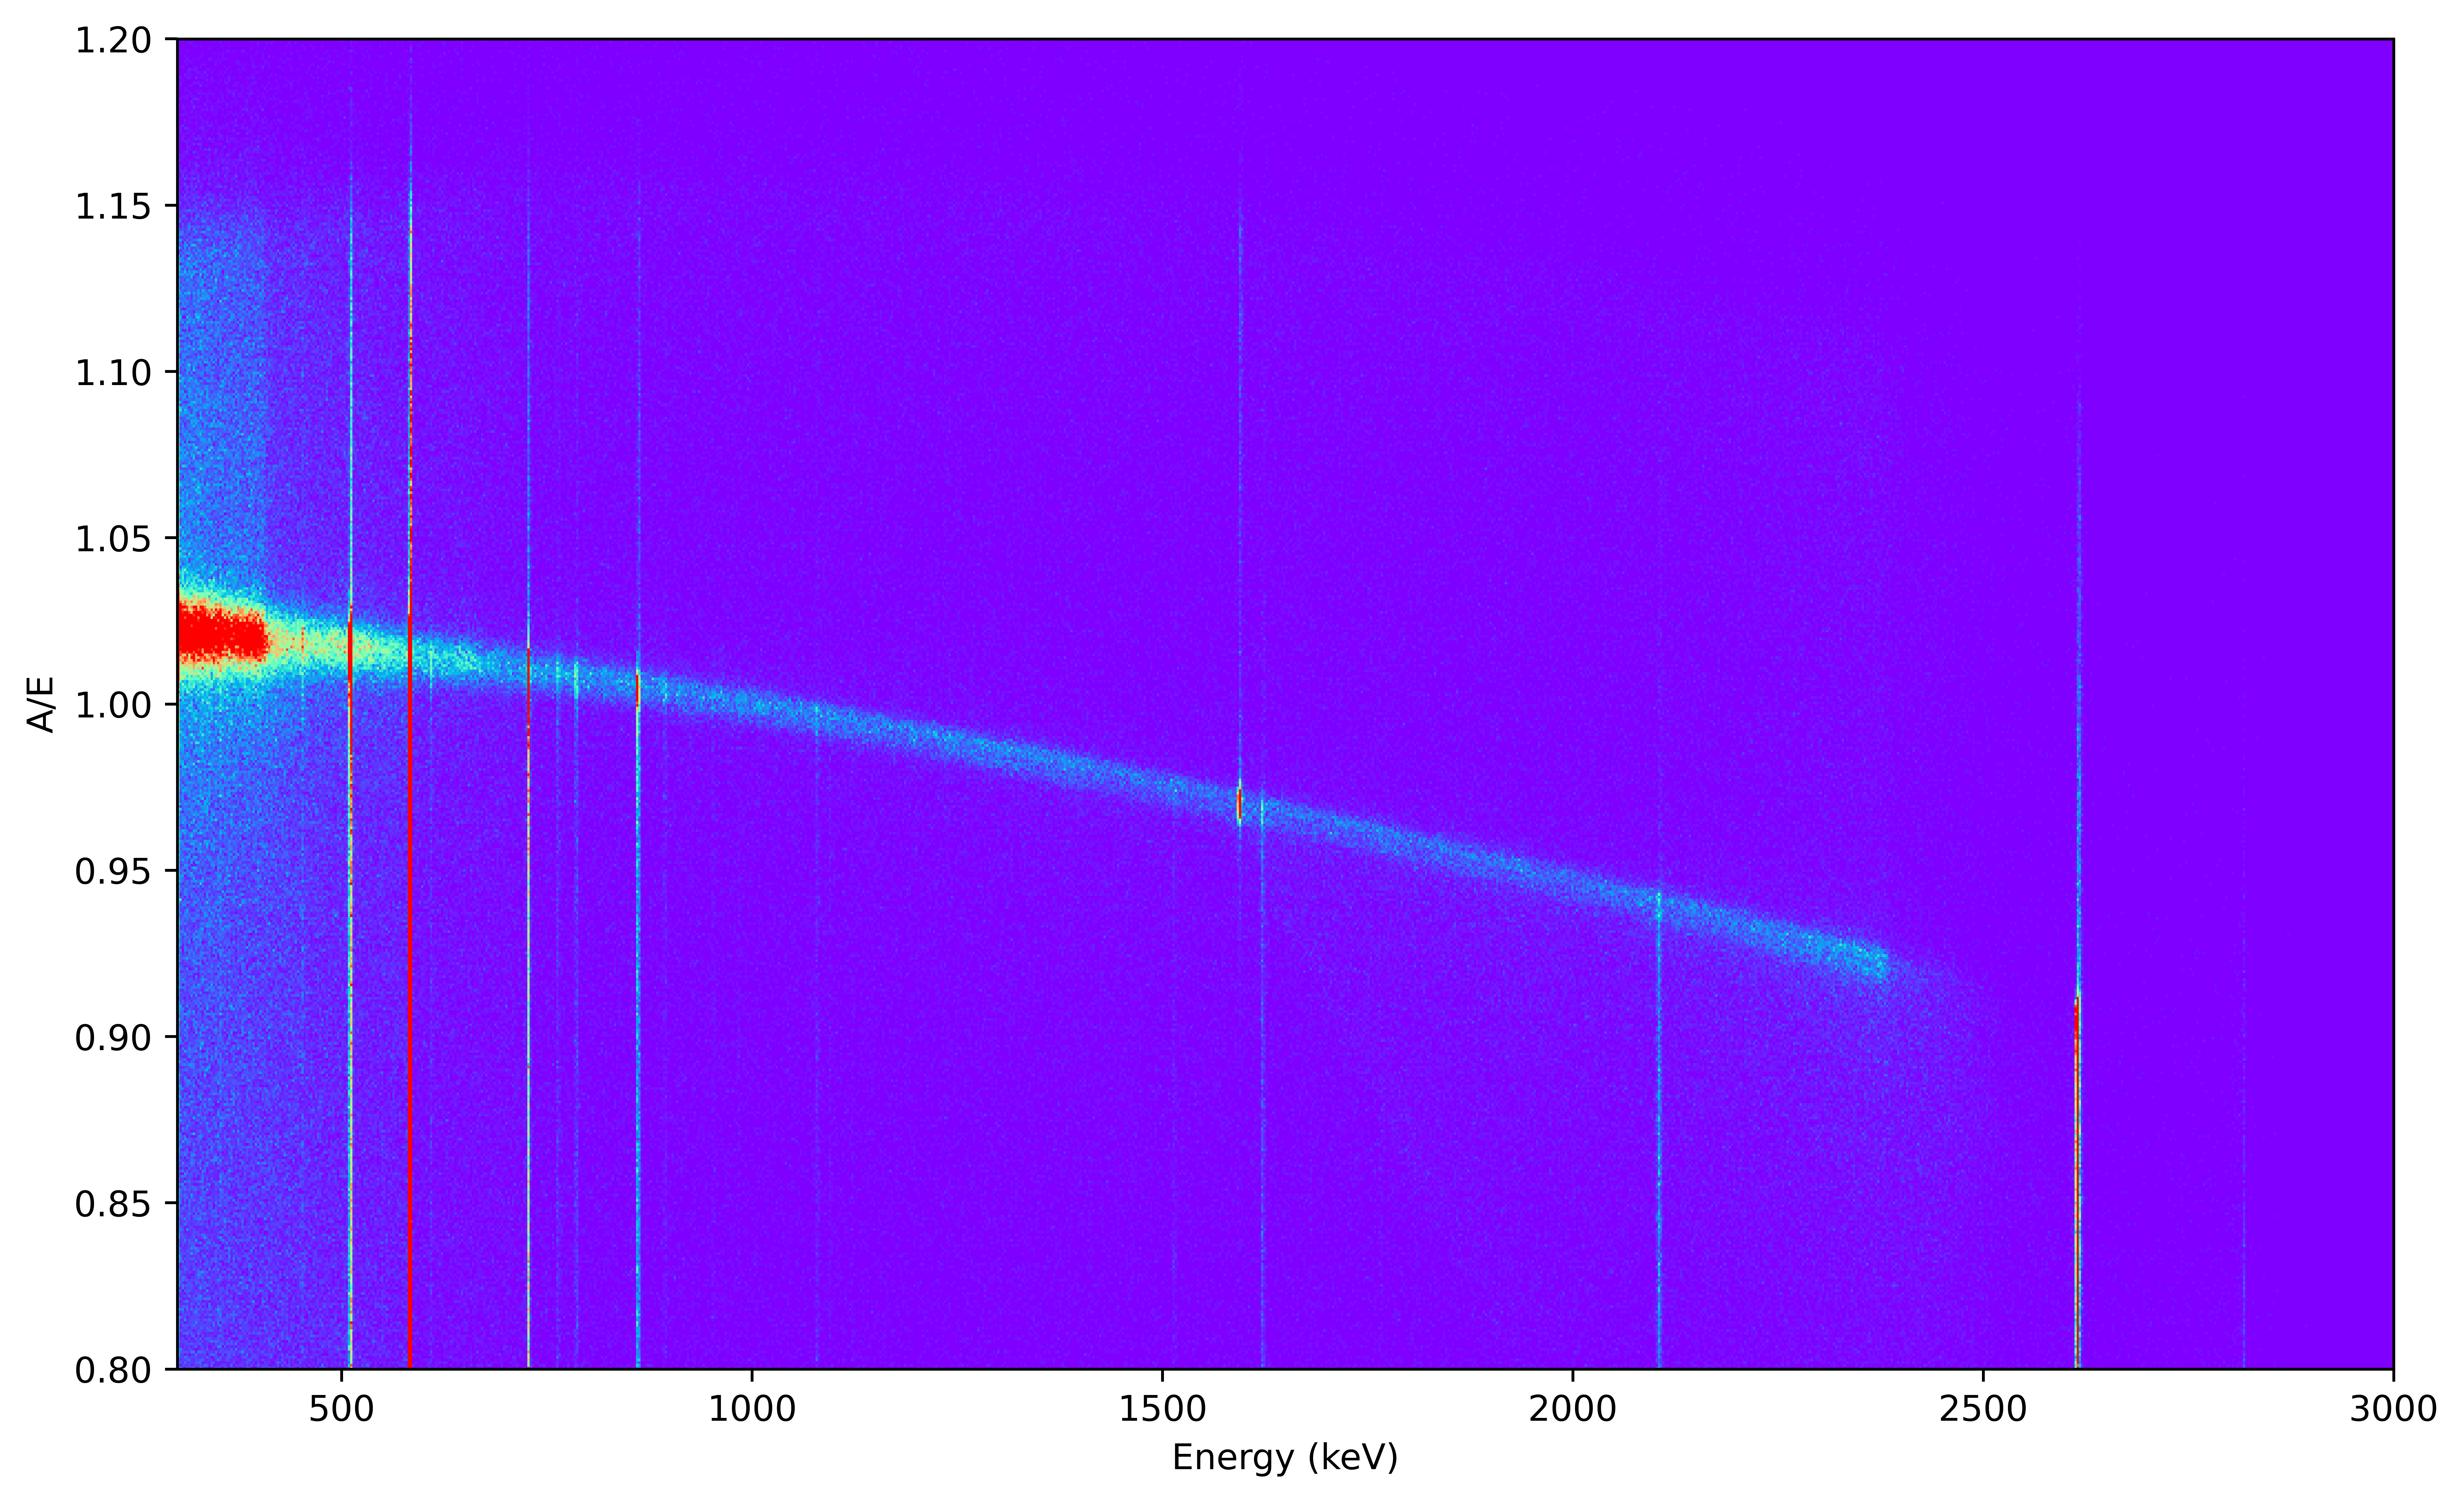

In [75]:
###draw AOE-E distribution
####draw set

def heat_plot(plot_bins_,plot_range_,Energy_=Energy, AOE_=AOE):
    heatmap, xedges, yedges = np.histogram2d(Energy,AOE_ ,bins=plot_bins_,range=plot_range_)
    cmap_ = copy.copy(mpl.cm.get_cmap("rainbow"))
    ax.pcolormesh(xedges, yedges,heatmap.T,cmap=cmap_,vmax=50)
    ax.set(xlabel='Energy (keV)',ylabel='A/E')  

#############
##plot heat map
fig, ax = plt.subplots(1,1,figsize=(10, 6),dpi=900)
heat_plot_bins=[1000,500]
heat_plot_range=[[300,3000],[0.8,1.2]]

heat_plot(heat_plot_bins,heat_plot_range,Energy, AOE)

plt_adjust()

plt.show()
#fig.savefig(r"E:\CDEX\0vbb\Figure\A\MWA_AE_C1B_cut_2sigma.png")

[7.6000e+02 8.4875e-01 4.0000e-03]
[6.62e+02 8.45e-01 4.00e-03]
[4.440e+02 8.375e-01 4.000e-03]
[4.4400e+02 8.3375e-01 4.0000e-03]
[3.6600e+02 8.2625e-01 4.0000e-03]
[3.9100e+02 8.1875e-01 4.0000e-03]
[4.8900e+02 8.1125e-01 4.0000e-03]
[7.2100e+02 8.0375e-01 4.0000e-03]
[8.060e+02 7.925e-01 4.000e-03]


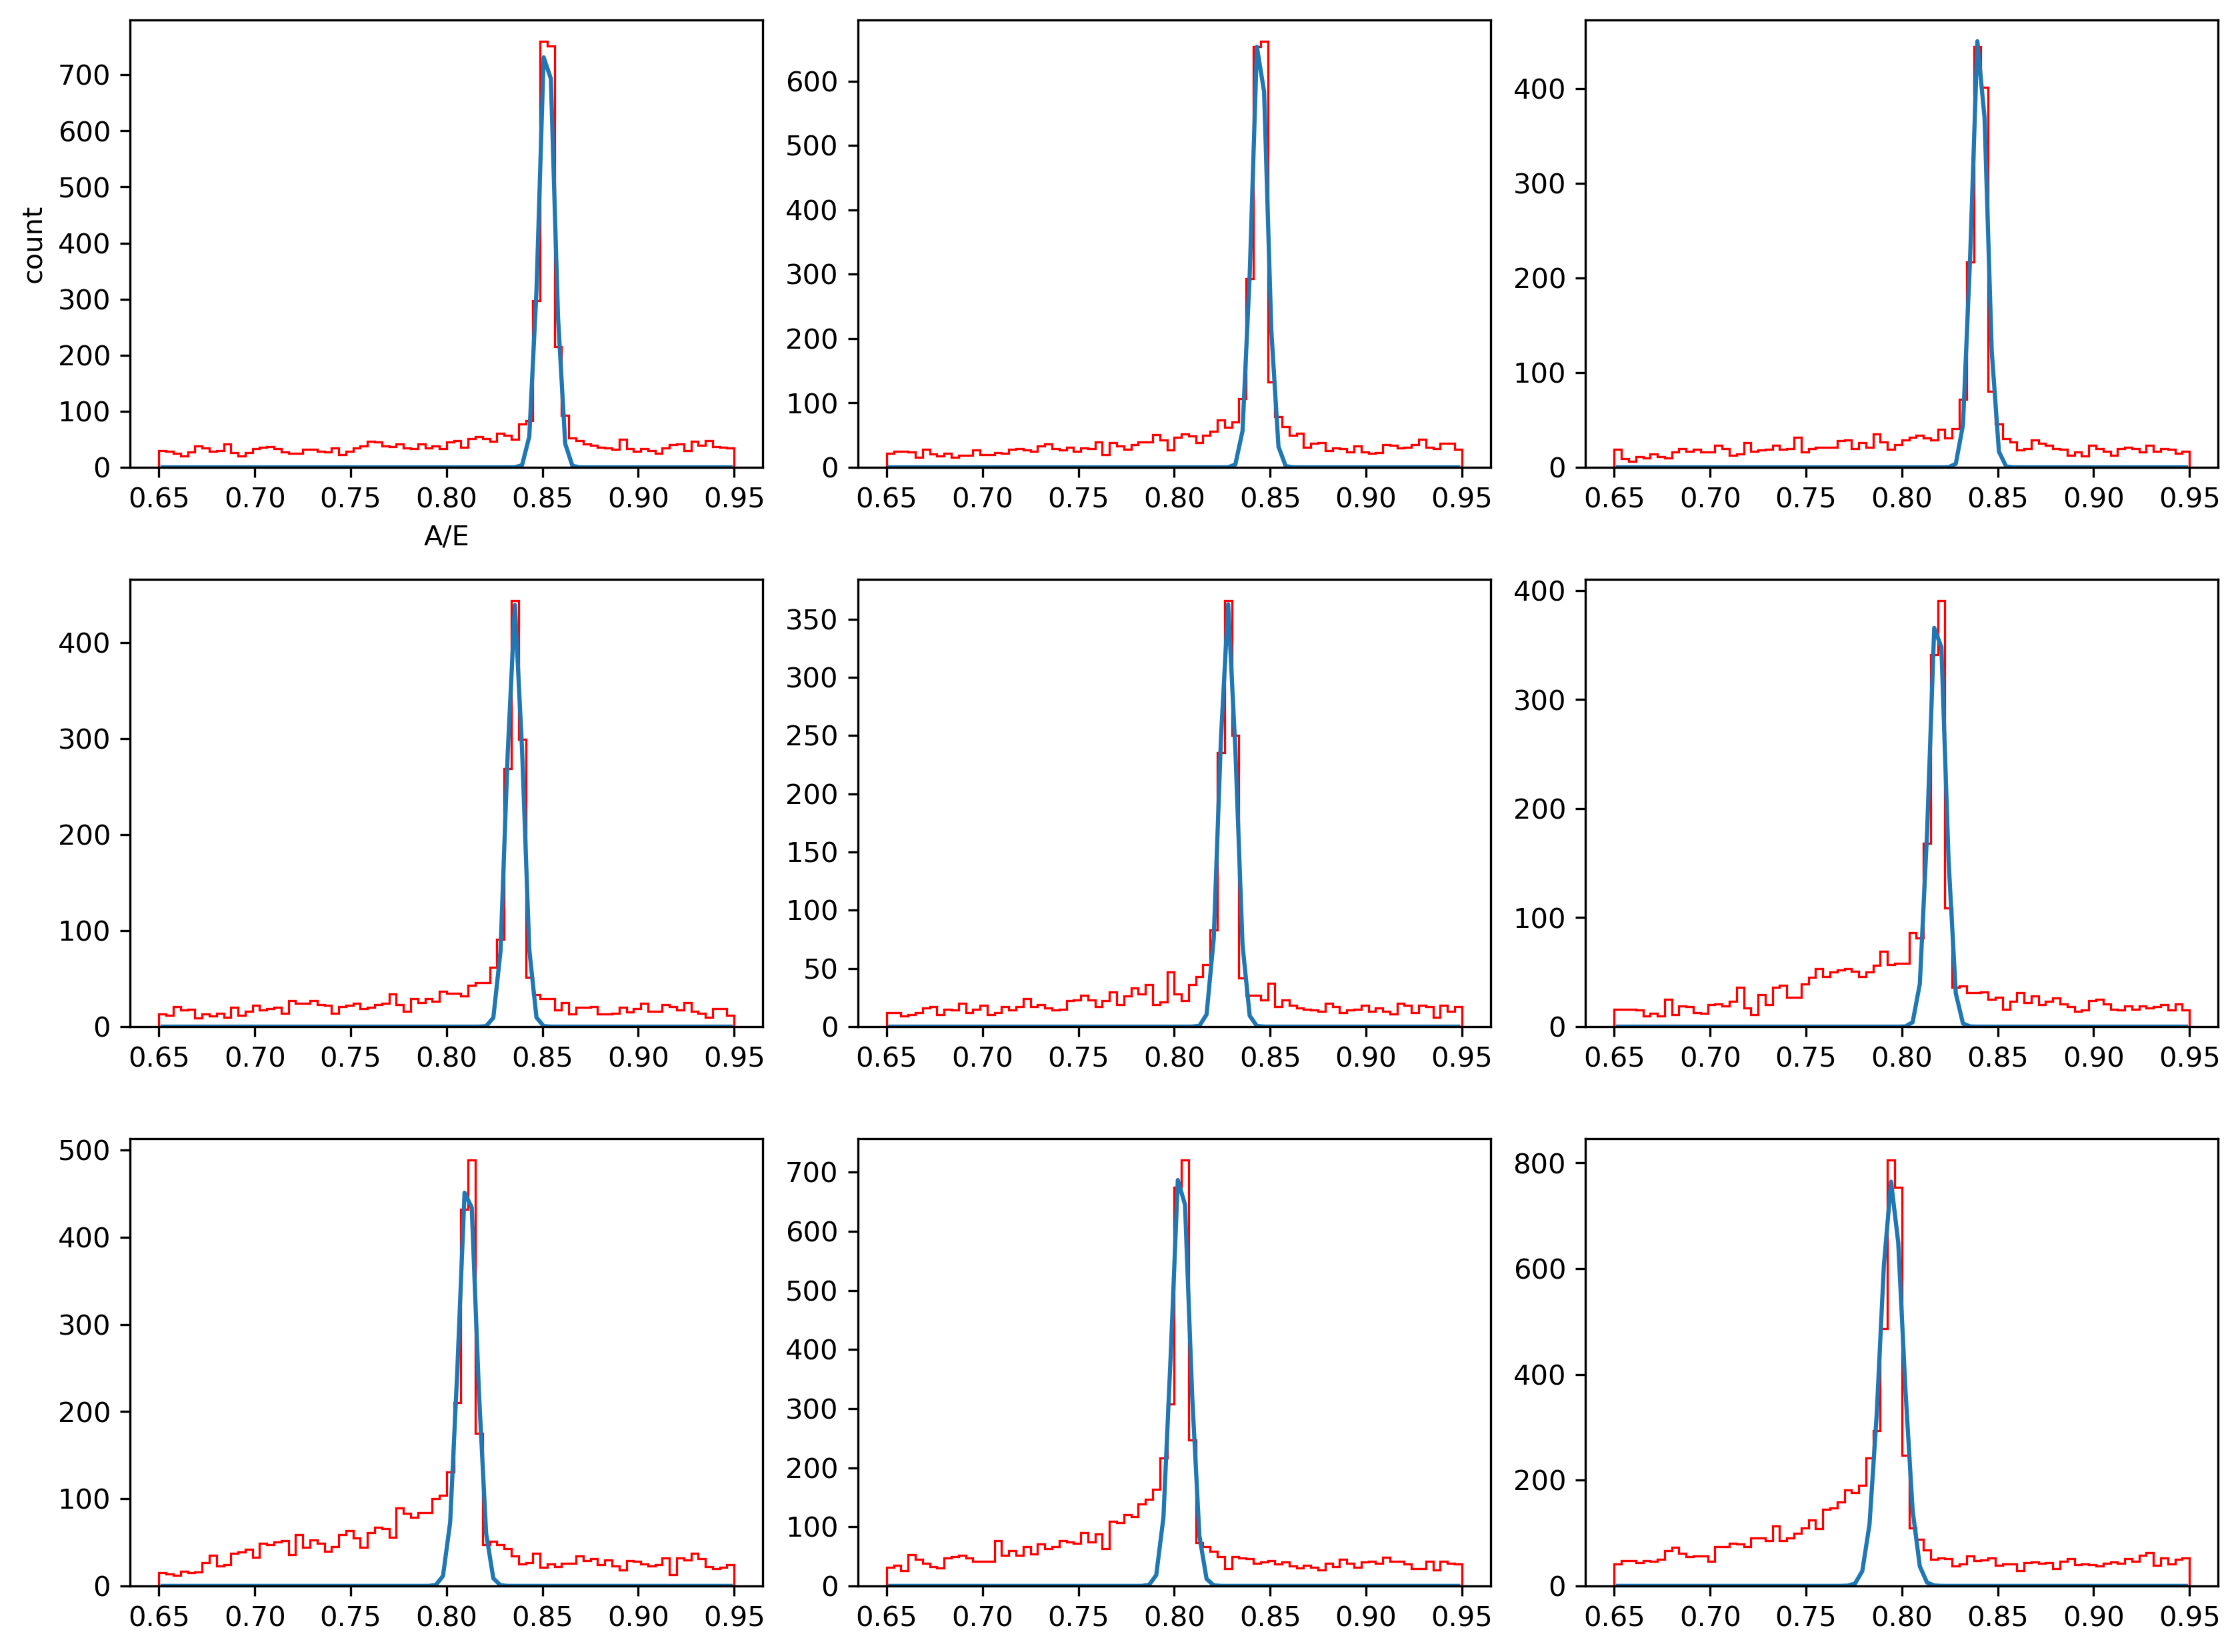

In [5]:
rough_opt,rough_cov=rough_fit(E_fit_point,Fit_point_range,Energy,AOE)

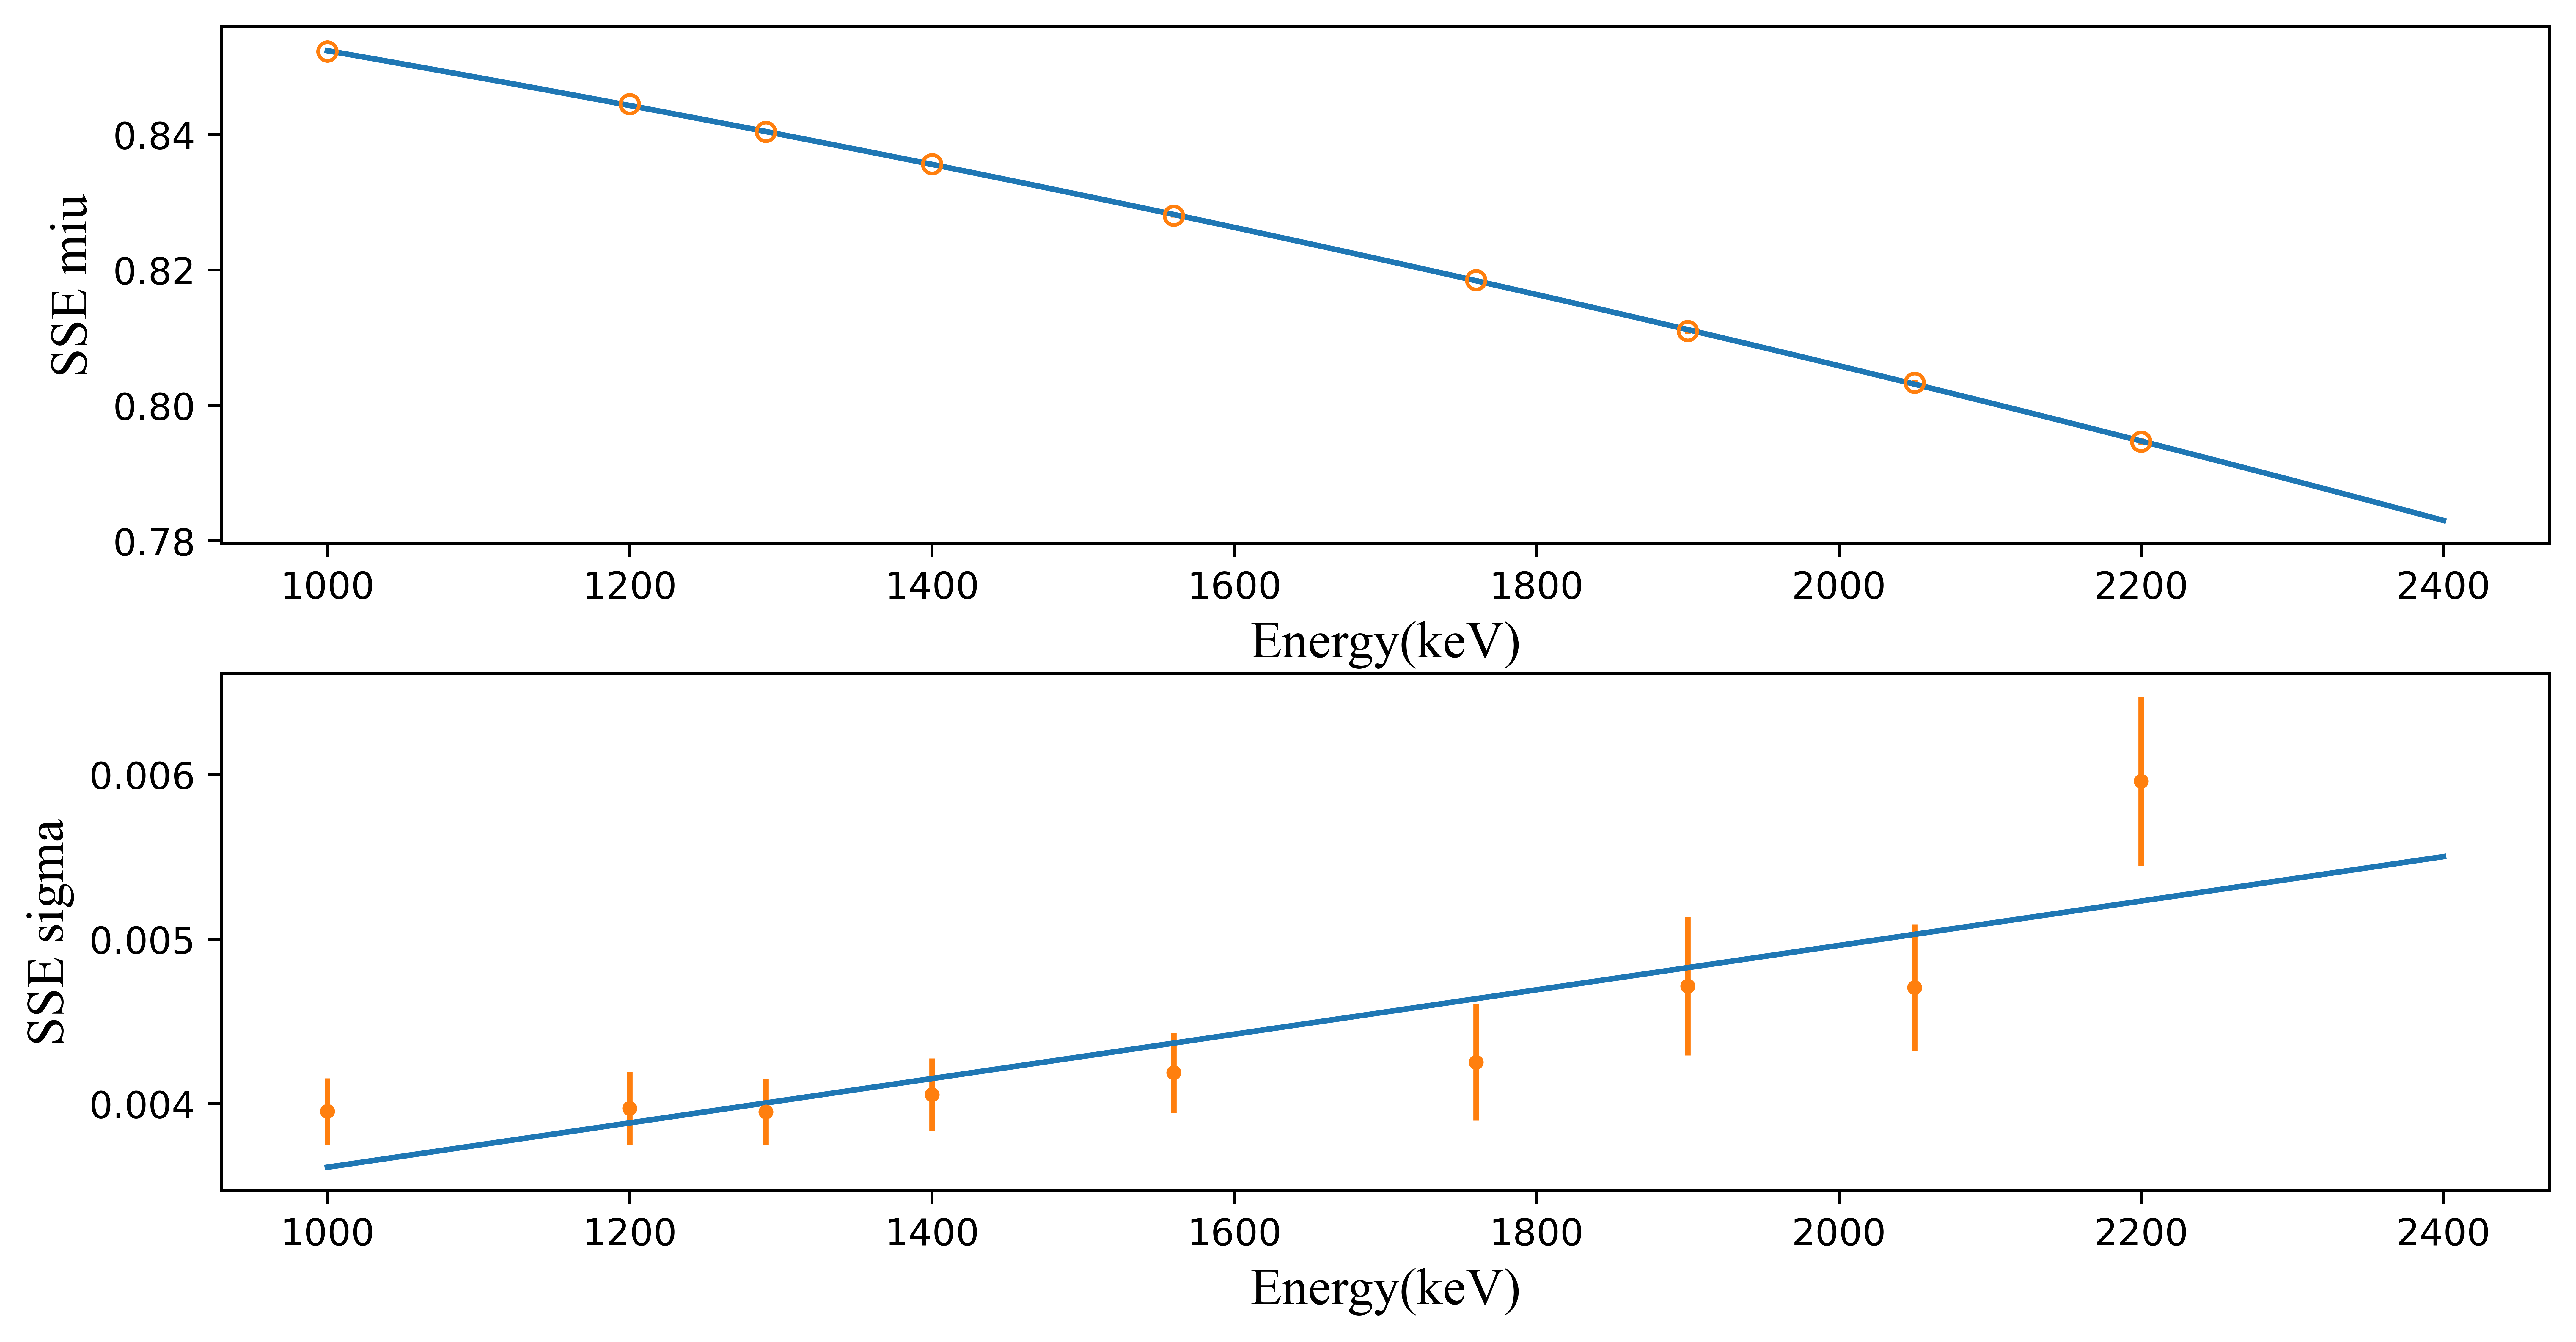

In [6]:
sse_mean_par_rough,sse_sigma_par_rough=fit_sse_E(rough_opt,rough_cov,E_fit_point)

In [7]:
sse_opt,sse_cov=accurate_fit(sse_mean_par_rough,sse_sigma_par_rough,Energy,AOE)#,save_path=pic_path+'AOE_SSE_MSE_fit.svg')

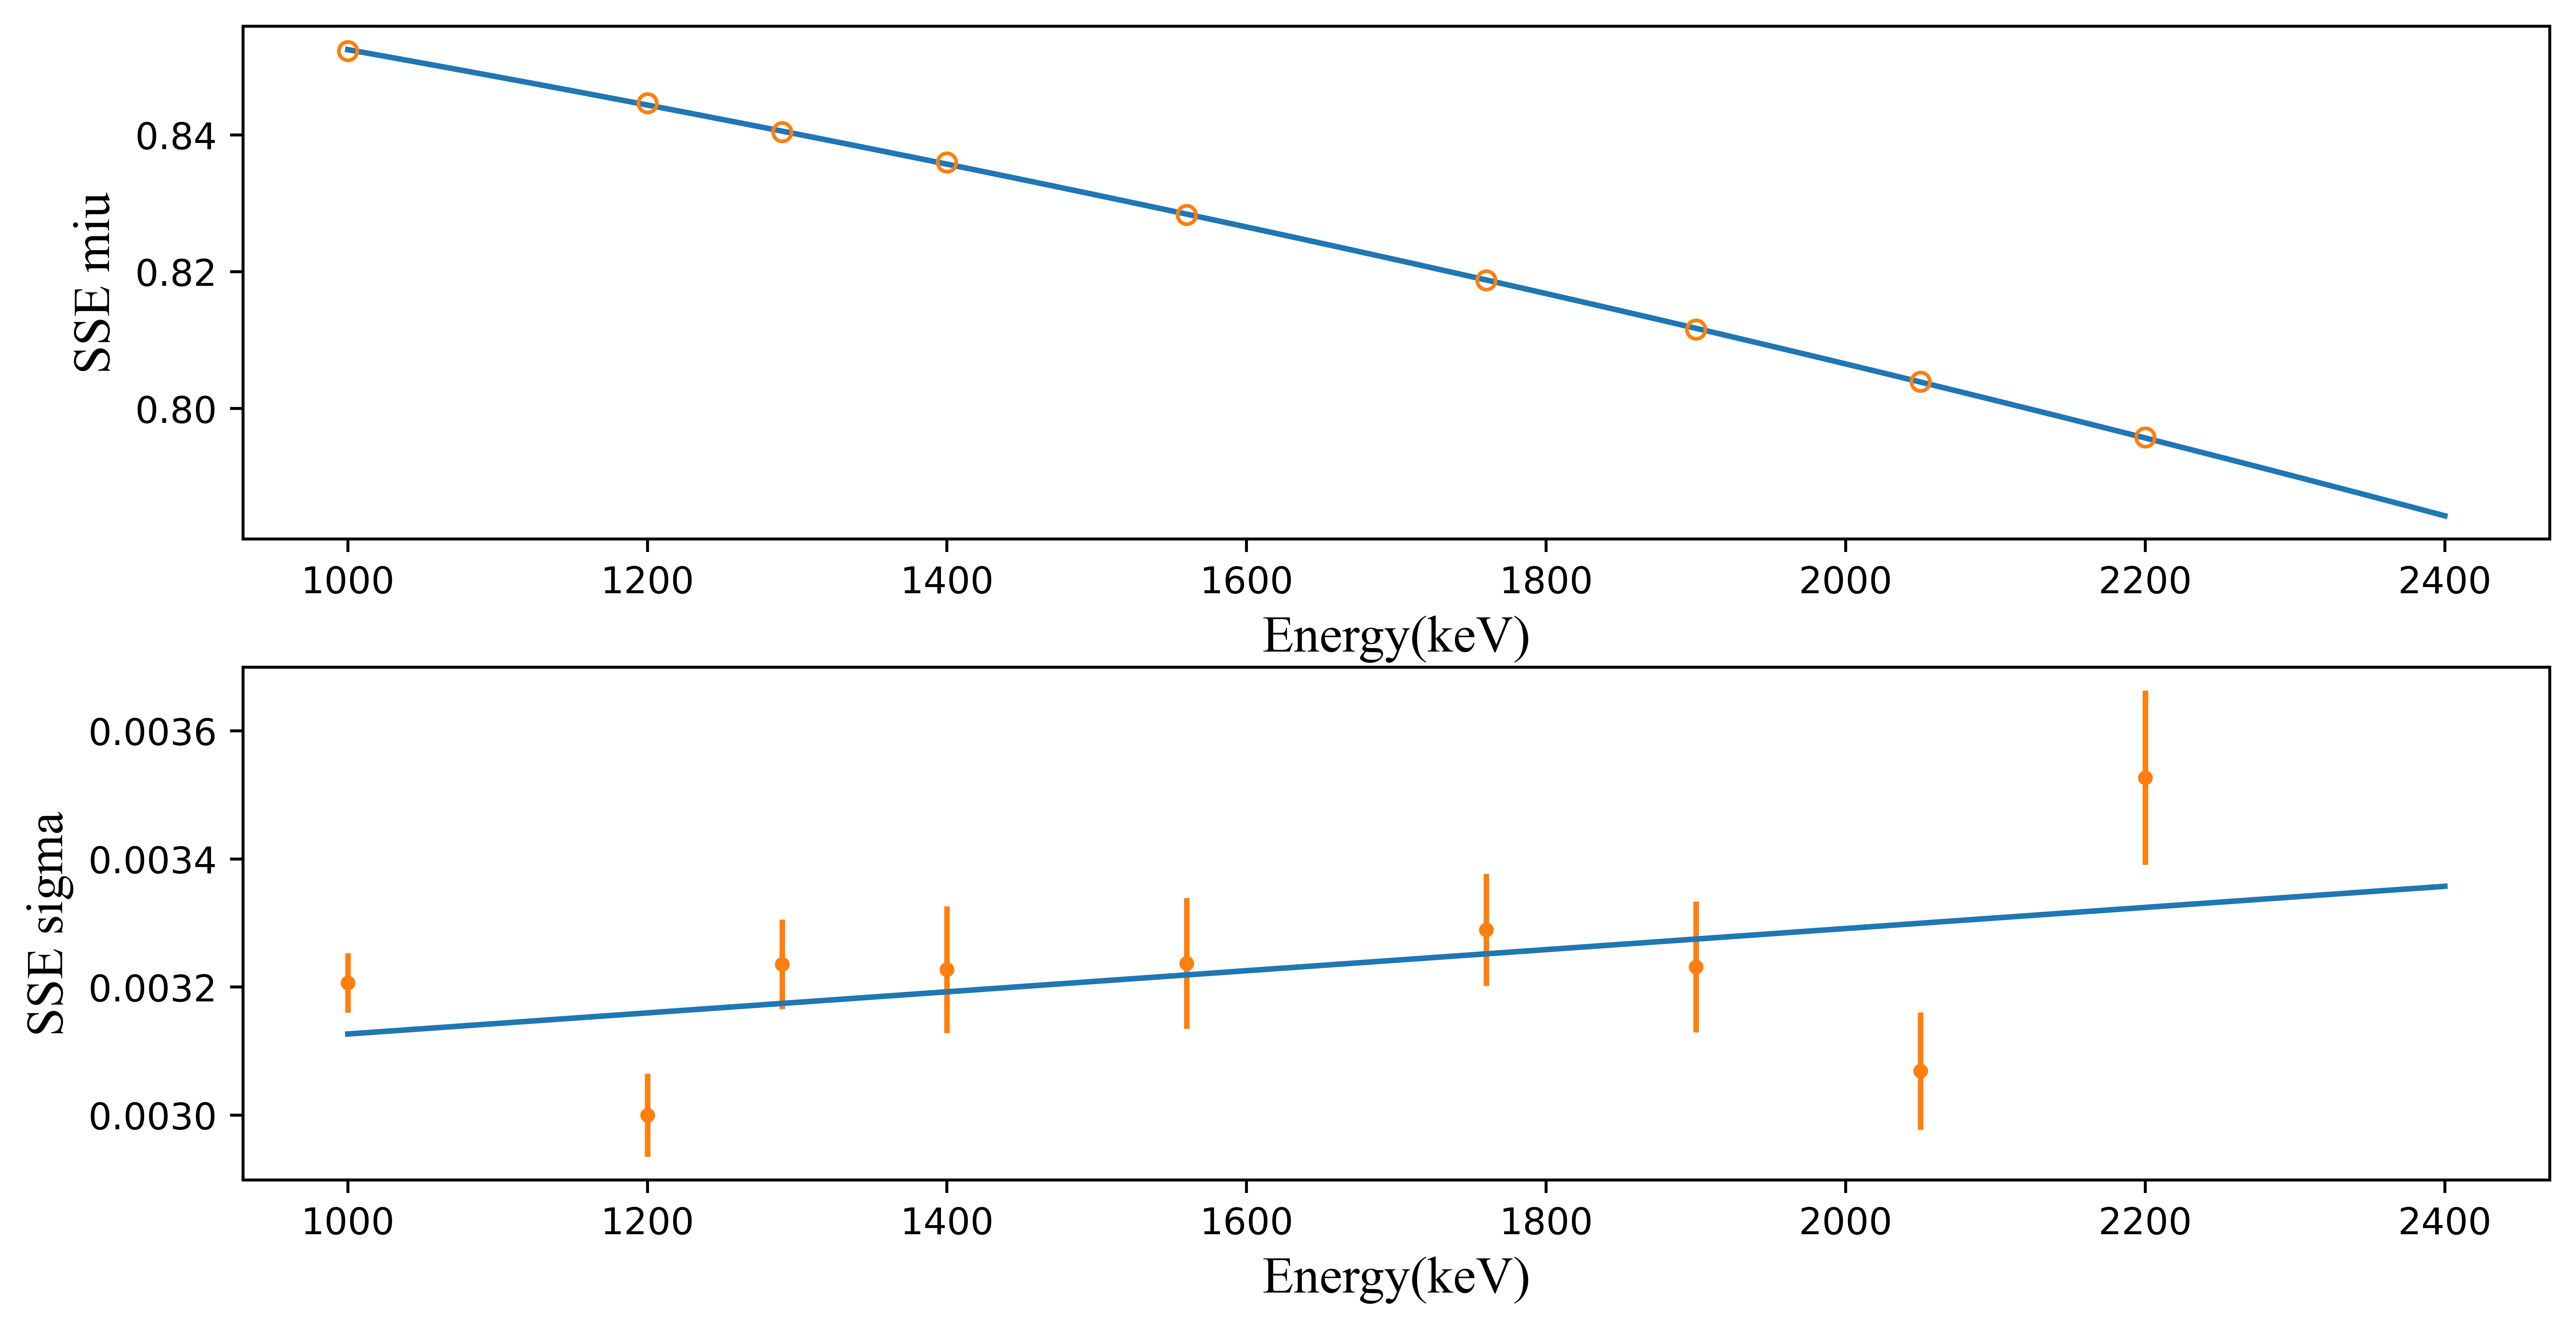

[ 8.84744983e-01 -2.54357862e-05 -6.83589143e-09] [2.96210967e-03 1.64669487e-07 1.87582140e-23]


In [8]:
upar,sigmapar=fit_sse_E(sse_opt,sse_cov,E_fit_point)#,save_path=pic_path+'sse_E_fit.svg')
print(upar,sigmapar)

In [20]:

normalize_=poly(1000,upar[0],upar[1],upar[2])
print(normalize_)
print([up/normalize_ for up in upar])
print([sigp/normalize_ for sigp in sigmapar])

0.852473305276726
[1.0378565258016592, -2.983763373169543e-05, -8.0188920699638e-09]
[0.0034747242597258413, 1.931667367420915e-07, 2.2004459080937865e-23]


0.1540305663769853
0.10548396763560083
0.36769553491159723
3337


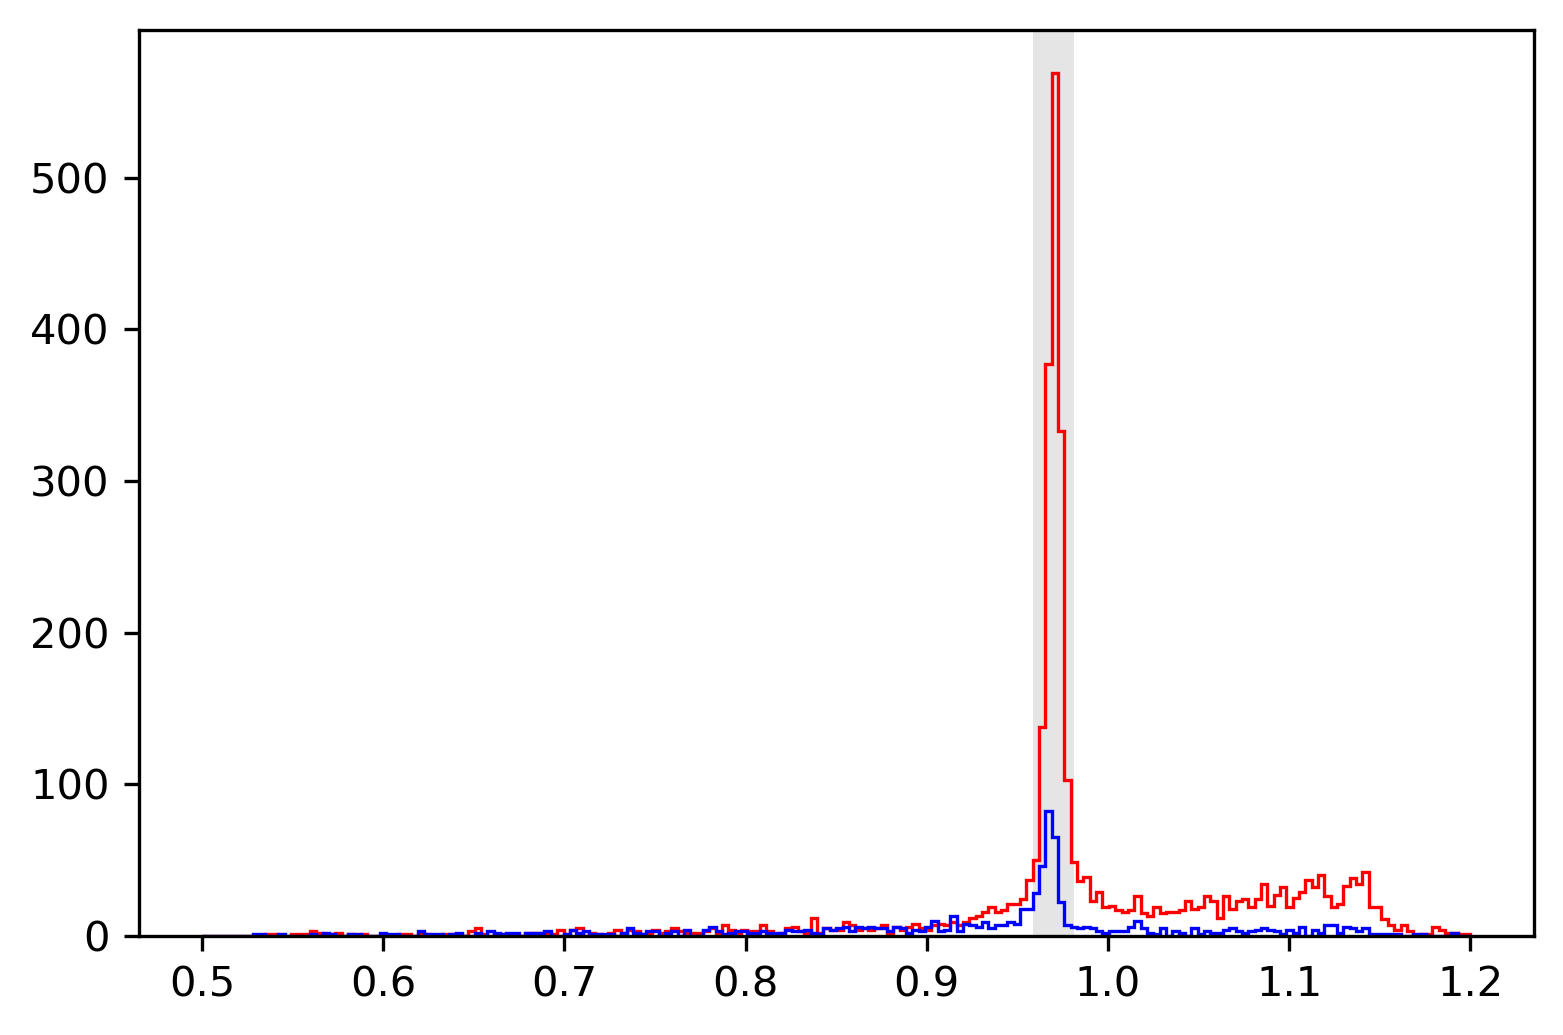

In [89]:
###计算A/E cut 的效率
##使用E刻度的结果：
## 对先前的E做残差校正，得到精确的E_corrected
def E_residual_correction(E):#可能适用于高能区，关注低能区时还是使用主放的刻度结果吧
    ##三个参数对应的标准差是1.36950620e-01 2.78530318e-04 9.60822919e-08
    residual=poly(E,-1.07813878e+00,  2.80900668e-03, -9.02120397e-07)
    return residual
def E_corrected_calibrate_amp(ch2_amp):
    E_rough=0.19265*ch2_amp-2.22
    return E_rough-E_residual_correction(E_rough)
def E_corrected_calibrate(E_rough):
    return E_rough-E_residual_correction(E_rough)
def SSE_mean(Energy):
    return poly(Energy,1.0378565258016592, -2.983763373169543e-05, -8.0188920699638e-09)
def SSE_sigma(Energy):
    return poly(Energy,0.0034747242597258413, 1.931667367420915e-07, 2.2004459080937865e-23)
def AE_cut_range(Energy,down,up):
    mean=SSE_mean(Energy)
    sigma=SSE_sigma(Energy)
    return [mean+down*sigma,mean+up*sigma]


def AE_cut_eff(Energy,AOE,down,up):
    E_corrected=E_corrected_calibrate(Energy)
    AOE_normalized=AOE/0.85247
    fig, ax = plt.subplots(1,1,figsize=(6, 4),dpi=300)
    energy_point=1592.7
    energy_range=2.7/2.355*3
    plot_bins=200
    plot_range=[0.5,1.2]
    
    AOE_DEP_event=AOE_normalized[np.argwhere((abs(E_corrected-energy_point)<energy_range))]
    AOE_DEP_event1=AOE_normalized[np.argwhere((abs(E_corrected-energy_point-20)<energy_range))]
    
    spec,bins,patchs=ax.hist(AOE_DEP_event,bins=plot_bins,range=plot_range,density=False,histtype='step',log=False,\
                      linewidth=0.8,color='red')
    spec1,bins1,patchs1=ax.hist(AOE_DEP_event1,bins=plot_bins,range=plot_range,density=False,histtype='step',log=False,\
                      linewidth=0.8,color='blue')
    
    cut_range=AE_cut_range(energy_point,down,up)
    
    ax.axvspan(cut_range[0],cut_range[1],facecolor='0.5',alpha=0.2)
    
    ####
    print(np.argwhere(AOE_DEP_event<cut_range[0]).shape[0]/AOE_DEP_event.shape[0])
    print(np.argwhere(AOE_DEP_event1<cut_range[0]).shape[0]/AOE_DEP_event.shape[0])
    print(np.argwhere(AOE_DEP_event>cut_range[1]).shape[0]/AOE_DEP_event.shape[0])   
    
    print(AOE_DEP_event.size)
    plt.show()

AE_cut_eff(Energy,AOE,-3,3)


<class 'numpy.ndarray'> (501,)


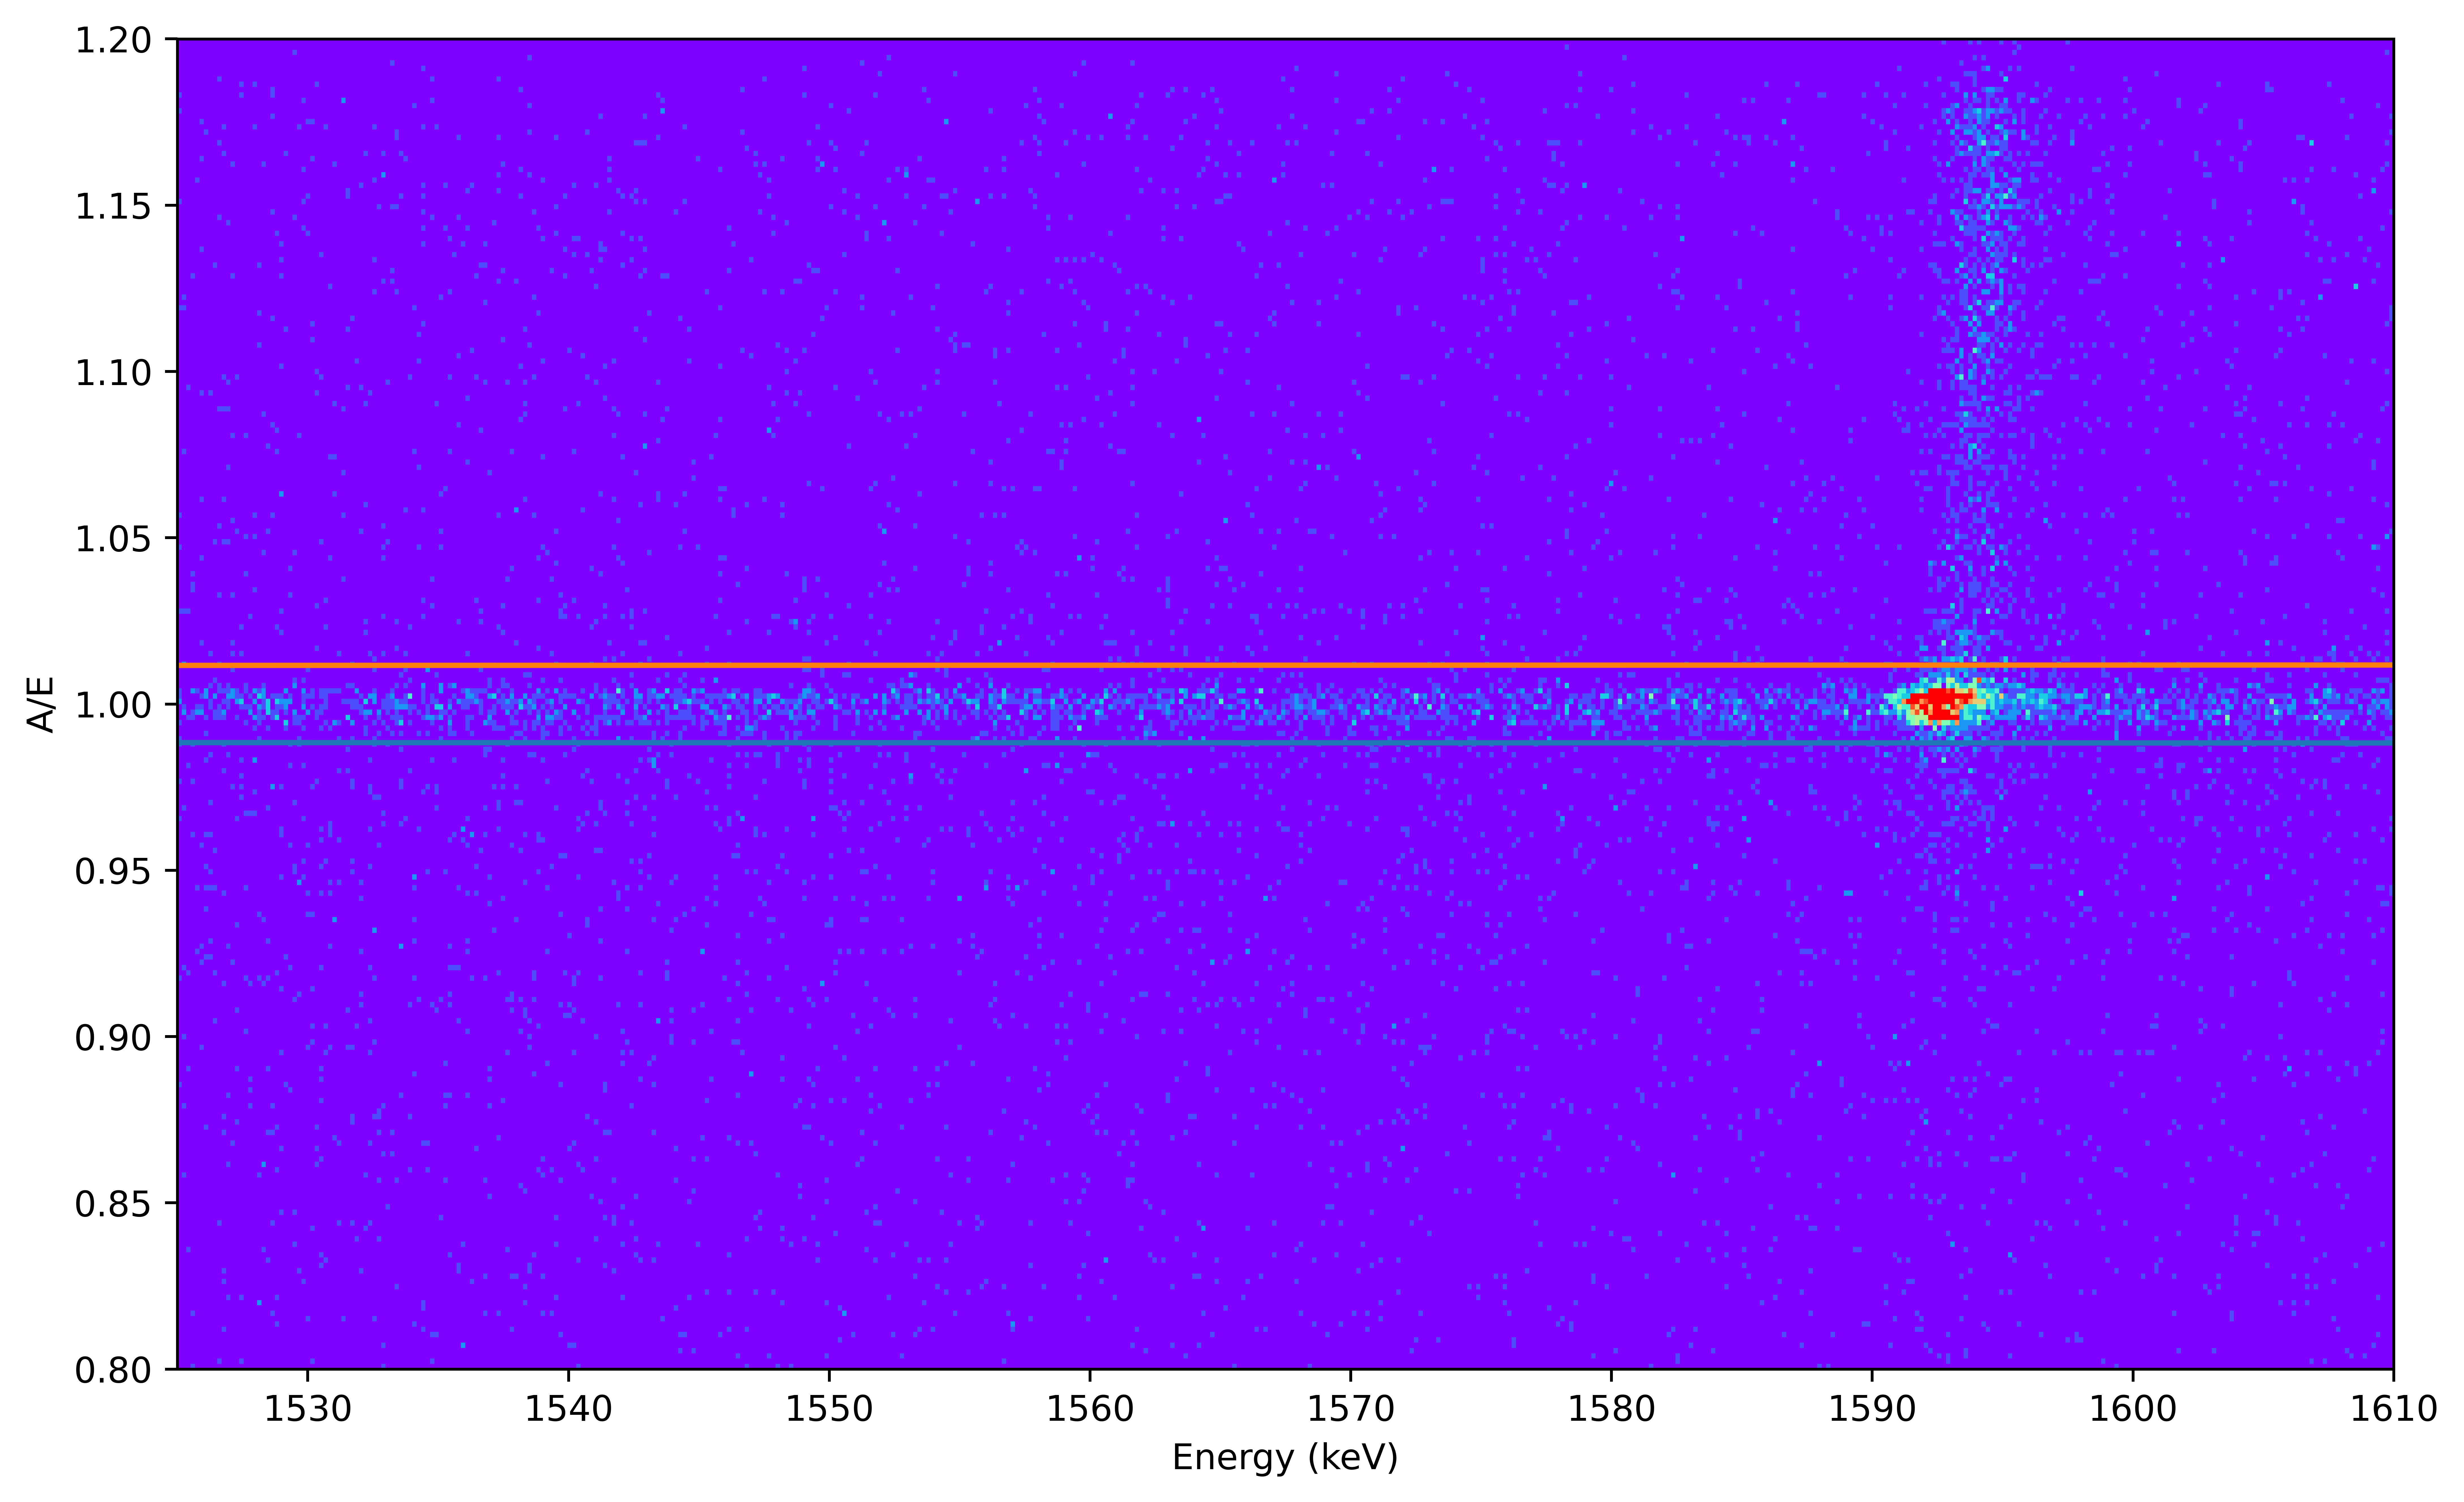

In [87]:
###draw AOE_Normalized -E distribution
####draw set

def heat_plot(plot_bins_,plot_range_,Energy_=Energy, AOE_=AOE):
    E_corrected=E_corrected_calibrate(Energy)
    AOE_normalized_all=AOE_/0.85247/SSE_mean(E_corrected)
    heatmap, xedges, yedges = np.histogram2d(E_corrected,AOE_normalized_all ,bins=plot_bins_,range=plot_range_)
    cmap_ = copy.copy(mpl.cm.get_cmap("rainbow"))
    ax.pcolormesh(xedges, yedges,heatmap.T,cmap=cmap_,vmax=10)
    print(type(xedges),xedges.shape)
    up=AE_cut_range(xedges,-3,3)[0]/SSE_mean(xedges)
    down=AE_cut_range(xedges,-3,3)[1]/SSE_mean(xedges)
    ax.plot(xedges,up)
    ax.plot(xedges,down)
    ax.set(xlabel='Energy (keV)',ylabel='A/E')  

#############
##plot heat map
fig, ax = plt.subplots(1,1,figsize=(10, 6),dpi=900)
heat_plot_bins=[500,250]
heat_plot_range=[[1525,1610],[0.8,1.2]]

heat_plot(heat_plot_bins,heat_plot_range,Energy, AOE)

plt_adjust()



plt.show()
#fig.savefig(r"E:\CDEX\0vbb\Figure\A\MWA_AE_C1B_cut_2sigma.png")

[2.47517622e+02 9.31310890e-01 6.10467700e-03 9.47770921e+02
 1.03586323e+01 9.02996053e-01 4.28908425e-36 1.49898351e-02
 2.41144355e+00 1.00000000e-02]


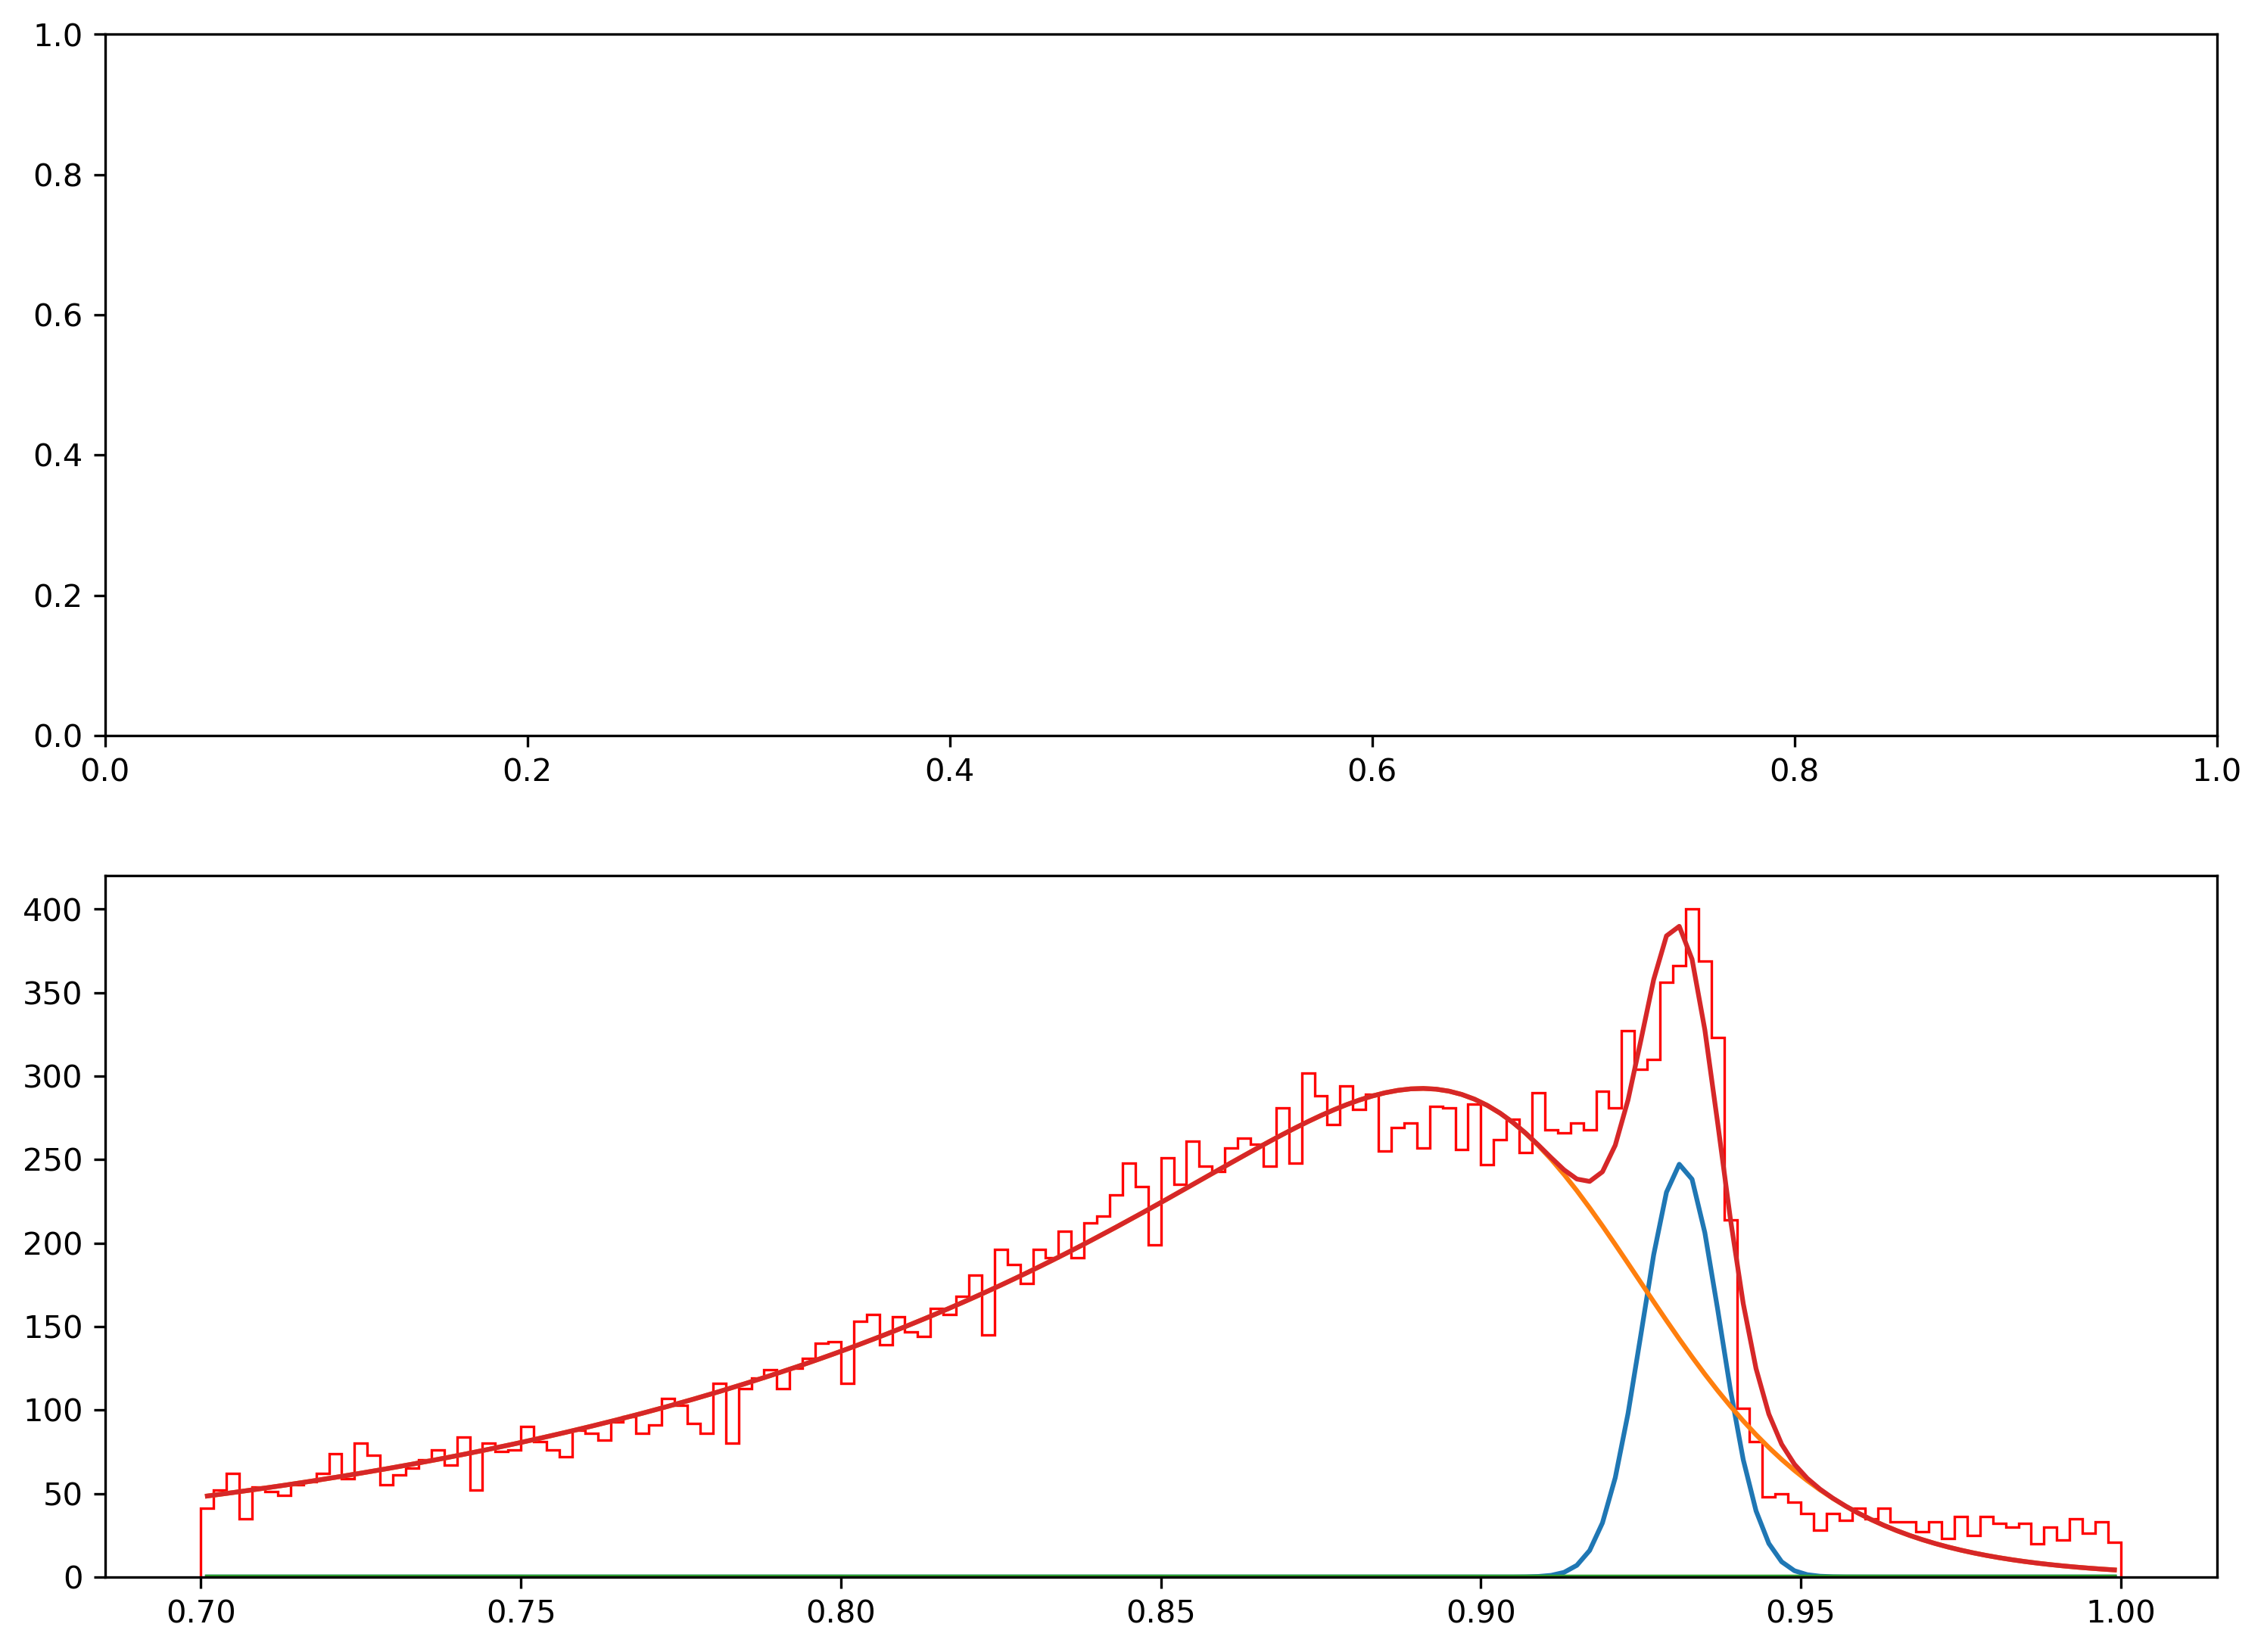

In [122]:
plot_bins=150
plot_range=[0.7,1]
#plot_t=np.linspace(plot_range[0],plot_range[1],100)
Epoint=[2103,2614]
energy_range=3
###draw AOE-E distribution
####draw set
x=Energy
i=1
normalized=AOE[np.argwhere(abs(Energy-1592)<3),i].mean()
y=AOE[:,i]/normalized

bound=[[100,  0.92, 0.003,0,   1,   0.8,  0.,  0,  0.85,0],\
       [10000,0.945,0.01, 3000,400, 0.95, 0.2, 0.1,7,   0.01]]

fig, ax = plt.subplots(2,1,figsize=(12, 9),dpi=300)

for i in range(1,2):
    energy_point=Epoint[i]
    spec,bins,patchs=ax[i].hist(y[np.argwhere((abs(x-energy_point)<energy_range))],bins=plot_bins,range=plot_range,density=False,histtype='step',log=False,\
                              linewidth=0.8,color='red')
    plot_t=(bins[0:len(spec)]+bins[1:])/2
    optf,covf=curve_fit(AE_pdf,plot_t,spec,bounds=bound)
    sse=sse_pdf(plot_t,optf[0],optf[1],optf[2])
    mse=mse_pdf(plot_t,optf[3],optf[4],optf[5],optf[6],optf[7],optf[8])
    tail=uper_tail(plot_t,optf[9],optf[5])
    
    ax[i].plot(plot_t,sse)
    ax[i].plot(plot_t,mse)
    ax[i].plot(plot_t,tail)
    ax[i].plot(plot_t,sse+mse+tail)
    print(optf)
    #mse=c1b_mse_pdf(t,optf[3],optf[4],optf[5],optf[6],optf[7],optf[8])


In [9]:
#######plot SSE MSE dist around DEP and SEP
energy_point=2104
energy_range=3
energy_compton_1=energy_point-2*energy_range
#energy_compton_2=energy_point-10
plot_bins=81
plot_range=[0.6,1.2]

fig, ax = plt.subplots(1,1,figsize=(8, 6),dpi=1200)
spec,bins,patchs=ax.hist(y[np.argwhere((abs(x-energy_point)<energy_range))],bins=plot_bins,range=plot_range,density=False,histtype='step',log=False,\
                      linewidth=0.3,color='black',label='SEP peak A/E')
spec1,bins1,patchs1=ax.hist(y[np.argwhere((abs(x-energy_compton_1)<energy_range))],bins=plot_bins,range=plot_range,density=False,histtype='stepfilled',log=False,\
                      linewidth=0.3,color='steelblue',label='Compton A/E')
# spec2,bins2,patchs2=ax.hist(y[np.argwhere((abs(x-energy_compton_2)<energy_range))],bins=plot_bins,range=plot_range,density=False,histtype='step',log=False,\
#                       linewidth=0.3,color='blue')
substract=spec-spec1

ax.step((bins[1:]),substract,linewidth=0.0,color='red')

ax.fill_between(bins[1:]-0.5*(bins[1]-bins[0]),substract,0,step='mid',color='crimson',label='SEP-Compton A/E')
ax.legend()
ax.set_ylim(0,350)
ax.set(xlabel='A/E')
plt.subplots_adjust(left=0.10, bottom=0.10, right=0.97, top=0.97,
                wspace=0.15, hspace=0.25)
fig.savefig(r"E:\CDEX\0vbb\Figure\A\MWA_%d.png"%i)

[ 8.83063165e-01 -2.28162081e-05 -7.87208362e-09]
[ 7.70213866e-03 -6.30745388e-06  2.43795527e-09]
[ 9.06169581e-01 -4.17385697e-05 -5.58217804e-10]
[ 8.59956749e-01 -3.89384643e-06 -1.51859494e-08]


In [114]:
print("sse u     =0.8831 - 2.282*E -7.872*E^2")
print("sse sigma =0.0077 - 6.307e-6 *E -2.438e-9 *E^2")

sse u     =0.8831 - 2.282*E -7.872*E^2
sse sigma =0.0077 - 6.307e-6 *E -2.438e-9 *E^2


In [186]:
print(linear(1592,upar[0],upar[1]),linear(1592,sgimapar[0],sgimapar[1]))
print(linear(2103.5,upar[0],upar[1]),linear(2103.5,sgimapar[0],sgimapar[1]))
sseu=linear(1592,upar[0],upar[1])
ssesigma=linear(1592,sgimapar[0],sgimapar[1])
mseu=linear(2103,upar[0],upar[1])
msesigma=linear(2103,sgimapar[0],sgimapar[1])
n=2
SSECUT=[sseu+2*ssesigma,sseu-2*ssesigma]
MSECUT=[mseu+2*msesigma,mseu-2*msesigma]

DEPindex=np.argwhere(abs(x-1592)<3)
SUM=len(DEPindex)

SSEC=len(np.argwhere(abs(y[DEPindex]-sseu)/ssesigma<3))
print(SUM,SSEC,SSEC/SUM)
#print(len(np.argwhere(abs(y[DEPindex]-sseu)/ssesigma<2)))

1.0436775763417574 0.011285510593314459
1.0166068157792922 0.010327934984145314
2408 1686 0.7001661129568106


In [209]:
SUM=0
for i in range(len(substract)):
    if(substract[i]<=0):
        substract[i]=0
    SUM+=substract[i]
t=bins[1:]-0.5*(bins[1]-bins[0])

SSEC=0
for i in range(len(substract)):
    if(abs(t[i]-mseu)<=4*msesigma):
        SSEC+=substract[i]
print(SSEC,SUM,SSEC/SUM)
print(mseu,msesigma)

172.0 2013.0 0.08544461003477397
1.0166332779108294 0.010328871030684092


In [90]:
##########
Erange=[2000,2200]
fitrange=[2020,2180]

fit_range
yrange=[1e1,2e3]
threashold=2
Bin=300
x_label="Energy (keV)"
y_label="count"


fig, ax = plt.subplots(1,1,figsize=(10, 6),dpi=300)
spec,bins,patchs=ax.hist(Energy,bins=Bin,range=Erange,density=False,histtype='step',log=True,\
                      linewidth=0.3,color=['black'])#,'blue','red','green'
############# fit
bound=[[50, 2100,1,50,-0.5,-1], #,10,   -10,   2,  2,  0.1,0.01],\
       [1000,2106,4,200,0.5, 1]]#,500,  -1,  4,  5,  50, 0.3]]
# bound=[[10, 1590,1,10, 1615,1,50,-0.5,-1], #,10,   -10,   2,  2,  0.1,0.01],\
#        [1000,1594,4,1000,1625,4,200,0.5, 1]]#,500,  -1,  4,  5,  50, 0.3]]

E=(bins[0:len(spec)]+bins[1:])/2
marsk=np.where(E[np.where(E<fitrange[1])]>fitrange[0])
print(marsk)
optf,covf=curve_fit(peak_pdf,E[marsk],spec[marsk],bounds=bound)
drawE=np.linspace(fitrange[0],fitrange[1],1000)
sse=peak_pdf(drawE,optf[0],optf[1],optf[2],optf[3],optf[4],optf[5])
#mse=c1b_mse_pdf(t,optf[3],optf[4],optf[5],optf[6],optf[7],optf[8])
ax.plot(drawE+(bins[1]-bins[0])/2,sse,label="before %dsigma cut"%(threashold))

uppar=upar+threashold*sgimapar
lowpar=upar-threashold*sgimapar
spec1,bins1,patchs1=ax.hist(Energy[np.where(abs(y-poly(Energy,upar[0],upar[1],upar[2]))/poly(Energy,sgimapar[0],sgimapar[1],sgimapar[2])<threashold)],bins=Bin,range=Erange,density=False,histtype='step',log=True,\
                      linewidth=0.3,color=['blue'])#,'blue','red','green'
ax.set(xlabel=x_label,ylabel=y_label)
ax.set_ylim(yrange[0],yrange[1])
#ax.plot(bins,spec,linewidth=0.3,color='black')
plt.subplots_adjust(left=0.10, bottom=0.10, right=0.97, top=0.97,
                wspace=0.15, hspace=0.25)

############# fit
# bound1=[[10, 2100,1,10,-0.5,-1], #,10,   -10,   2,  2,  0.1,0.01],\
#        [1000,2106,4,100,0.5,1]]#,500,  -1,  4,  5,  50, 0.3]]

bound1=bound

E1=(bins1[0:len(spec1)]+bins1[1:])/2
marsk1=np.where(E1[np.where(E1<fitrange[1])]>fitrange[0])
print(marsk1)
optf1,covf1=curve_fit(peak_pdf,E1[marsk],spec1[marsk],bounds=bound1)
drawE1=np.linspace(fitrange[0],fitrange[1],1000)
sse1=peak_pdf(drawE1,optf1[0],optf1[1],optf1[2],optf1[3],optf1[4],optf1[5])
#mse=c1b_mse_pdf(t,optf[3],optf[4],optf[5],optf[6],optf[7],optf[8])
ax.plot(drawE1+(bins1[1]-bins1[0])/2,sse1,label="after  %dsigma cut"%(threashold))
ax.legend()
plt.show()

print("before %dsigma cut :"%(threashold), optf[0:3],np.diag(covf)[0:3])
print("after  %dsigma cut :"%(threashold), optf1[0:3],np.diag(covf1)[0:3])
print("count fraction    :", optf1[0]*optf1[2]/(optf[0]*optf[2]))
#fig.savefig(r"E:\CDEX\0vbb\Figure\A\C1B_cut_%dsigma_MSE_peak_newfit.png"%(threashold))

NameError: name 'fit_range' is not defined

In [ ]:
##plot A/E - E distribution and cut line

t=np.linspace(1000,2500,1000)
uppar=upar+2*sgimapar
lowpar=upar-2*sgimapar
uplimit=poly(t,uppar[0],uppar[1],uppar[2])
lowlimit=poly(t,lowpar[0],lowpar[1],lowpar[2])
ax.plot(t,uplimit,color='r')
ax.plot(t,lowlimit,color='r')